# tysserand tutorial

*tysserand* allows you to reconstruct networks from a Mx2 array containing the coordinates of  M points, or from an image resulting from a segmentation step. Segmentation is the detection of areas of interest  like cells or nuclei in microscopy images (details below).  
Here we will see how to reconstruct a network in 4 different ways, but remember: tysserand welcomes very much contributions for new reconstructions methods, automatic parameters setting or improved computational performance!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
from pathlib import Path
import time
import copy

In [2]:
# Convenient IPython console
# comment it if you execute Jupyterlab on a remote server

%qtconsole --style monokai

In [3]:
# If you haven't properly installed tysserand, but the repository is on your hard drive:
import sys
sys.path.extend(['../../tysserand']) # change directory accordingly

In [4]:
from tysserand import tysserand as ty

## Make a fake segmentation image

We will generate data mimicking what we can obtain after cell segmentation in an epithelium. For examples, check-out:
  - https://dev.biologists.org/content/144/9/1725
  - https://www.biorxiv.org/content/10.1101/2020.01.17.910562v1.full

In [5]:
# for reproducibility
np.random.seed(0)

In [6]:
coords, masks, image = ty.make_random_tiles(nb=10, return_image=True, noise_sigma=10)

`coords` is a 100x2 array containing the coordinates of "seeds" used to produce the "segmentation areas"

In [7]:
print(coords[:5,:])

[[ 18  19]
 [114   0]
 [231   0]
 [354  10]
 [462   0]]


`image` is really the image used to produce the areas, it contains only the "seeds" for the watershed algorithm

(<Figure size 648x648 with 1 Axes>, <AxesSubplot:>)

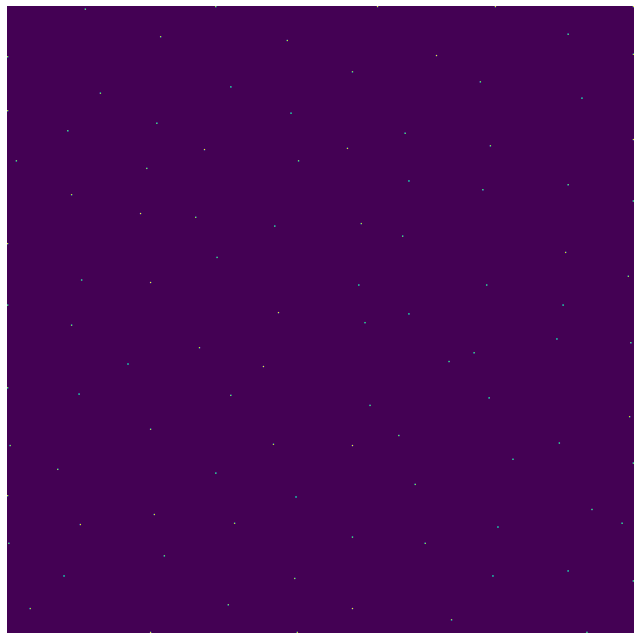

In [8]:
ty.showim(image, origin='lower')

`masks`is the segmentation image.  
It contains areas made of a single integer that refers to its segmentation object ID. Integers range from 0 to K for K detect areas, 0 encodes the background.

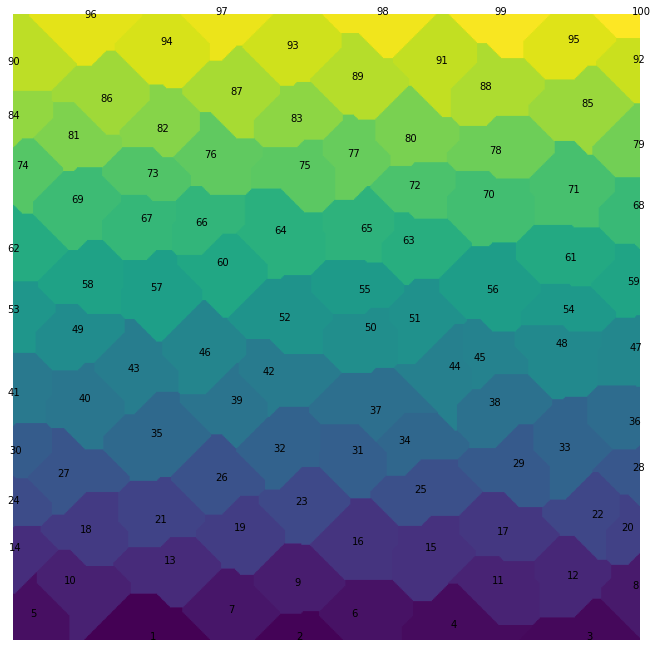

In [9]:
fig, ax = ty.showim(masks, origin='lower')
for (x,y) in coords:
    text = str(masks[y,x])
    plt.text(x-5, y, text, fontdict=None)

To see these areas with more contrast we can use a `scikit-image` function, but sometimes adjacent areas have exactly the same color due to cycling encoding of integer in the colormap.  
Is you know a utility to color-code areas taking advantage of the [4 colors theorem](https://en.wikipedia.org/wiki/Four_color_theorem) I'll be pleased to hear it! :-)

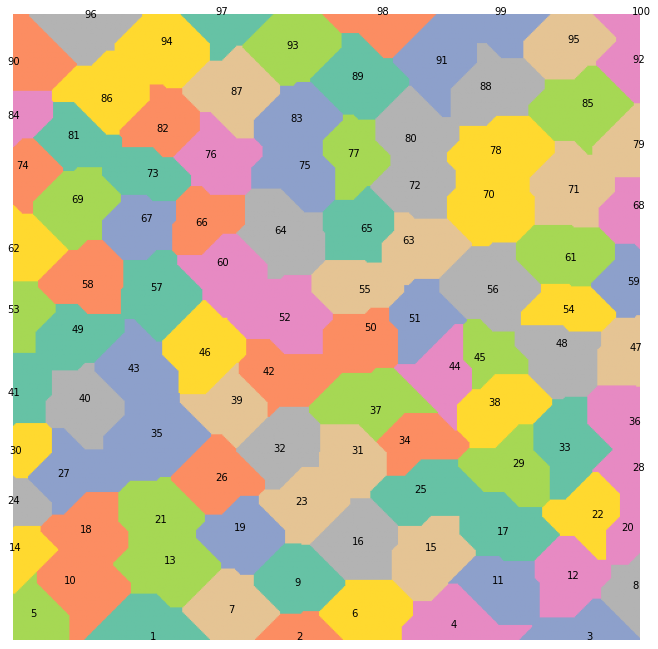

In [10]:
label_cmap = mpl.cm.get_cmap('Set2')(range(8))
from skimage import color

fig, ax = ty.showim(color.label2rgb(masks, bg_label=0, colors=label_cmap), origin='lower')
for (x,y) in coords:
    text = str(masks[y,x])
    plt.text(x-5, y, text, fontdict=None)

## Network reocnstruction

### Area contact

Here we define edges between nodes which areas are in direct contat, or closer than a user-defined distance.  
That is the most relevant method for actual segmentation images.

In [11]:
pairs = ty.build_contacting(masks)
# reencode the coordinates to match node positions with their respective areas
coords = ty.mask_val_coord(masks)
coords, pairs = ty.refactor_coords_pairs(coords, pairs)
distances = ty.distance_neighbors(coords, pairs)

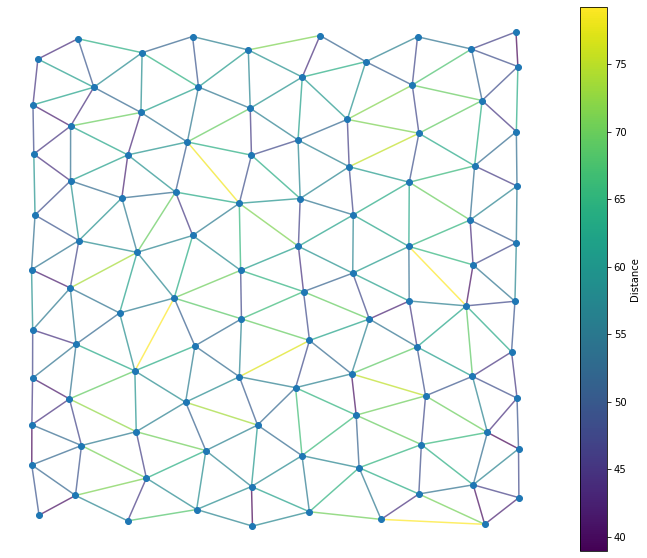

In [12]:
ty.plot_network_distances(coords, pairs, distances, figsize=(13,10))
plt.axis('off');

In [13]:
linewidth = 3

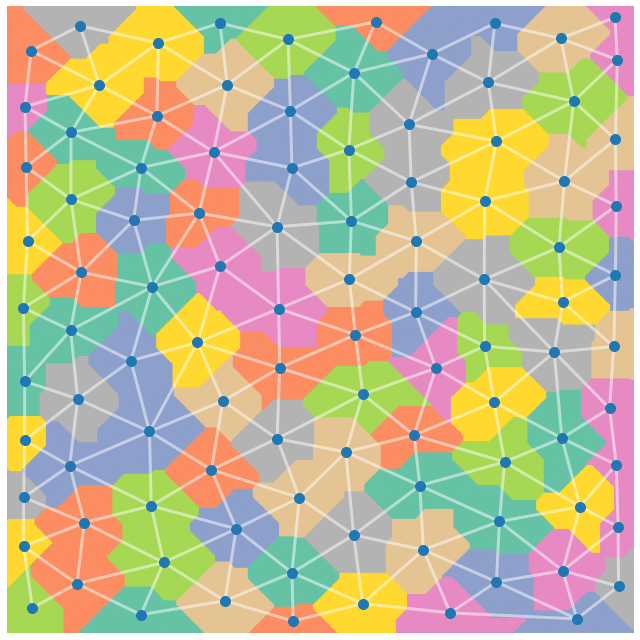

In [14]:
fig, ax = ty.showim(color.label2rgb(masks, bg_label=0, colors=label_cmap), origin='lower')
ty.plot_network(coords, pairs, col_edges='w', size_nodes=100, ax=ax, linewidth=linewidth)

### Delaunay triangulation

In case you *only* have areas positions, but not their boundaries (like if you stain the nuclei but not the membranes), [Delaunay triangulation](https://en.wikipedia.org/wiki/Delaunay_triangulation) produces networks that qualitatively mimick well *epithelium-like* networks. More precisely, edges are in the vast majority defined between actually contacting areas.

In [15]:
pairs = ty.build_delaunay(coords, trim_dist=False)
distances = ty.distance_neighbors(coords, pairs)

The `plot_network_distances` function helps you to define a distance threshold above with edges will be trimmed.

(-11.375231596171338, 511.2509826531721, -15.221645021645024, 514.756586270872)

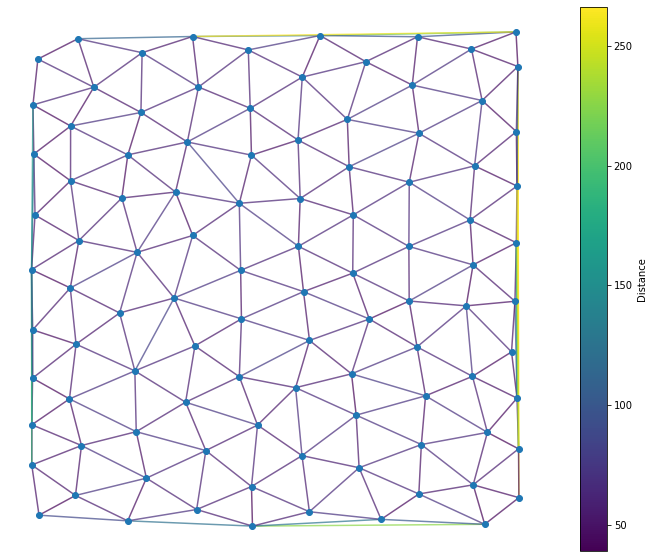

In [16]:
ty.plot_network_distances(coords, pairs, distances, figsize=(13,10))
plt.axis('off')

In [17]:
dist_threshold = 110
select = distances < dist_threshold
pairs = pairs[select,:]

(-11.375231596171338, 511.2509826531721, -15.221645021645024, 514.756586270872)

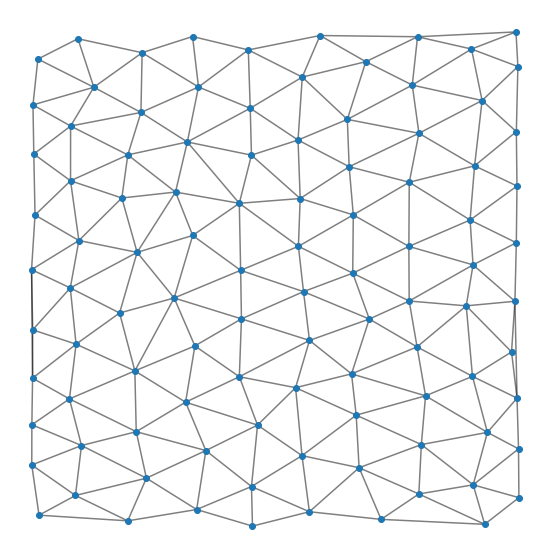

In [18]:
ty.plot_network(coords, pairs, figsize=(10,10))
plt.axis('off')

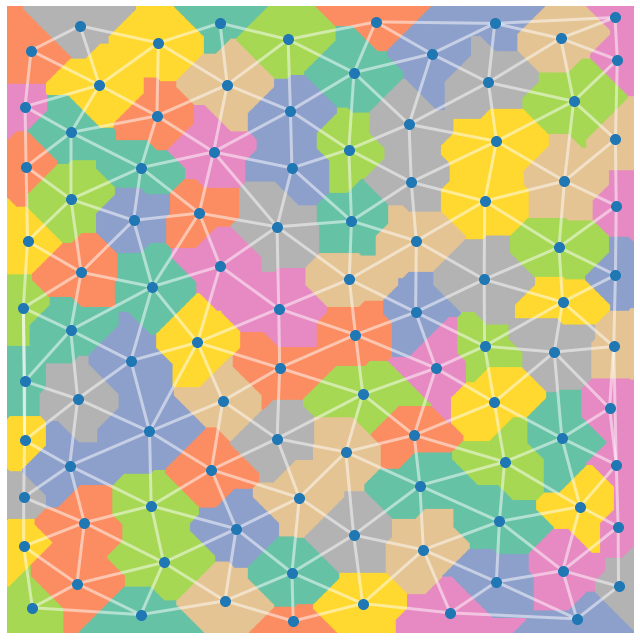

In [19]:
fig, ax = ty.showim(color.label2rgb(masks, bg_label=0, colors=label_cmap), origin='lower')
ty.plot_network(coords, pairs, col_edges='w', size_nodes=100, ax=ax, linewidth=linewidth)

### k-nearest neighbors

k-nearest neighbors (knn) is probably the most common network reconstruction method. In this method, nodes are linked with their knn, you have to choose k.

In [20]:
pairs = ty.build_knn(coords, k=6)
distances = ty.distance_neighbors(coords, pairs)

(-11.375231596171338, 511.2509826531721, -15.221645021645024, 514.756586270872)

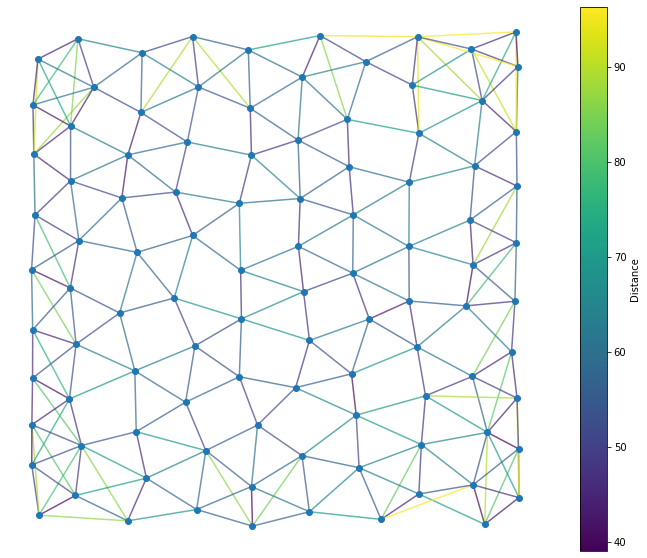

In [21]:
ty.plot_network_distances(coords, pairs, distances, figsize=(13,10))
plt.axis('off')

(-0.5, 499.5, -0.5, 499.5)

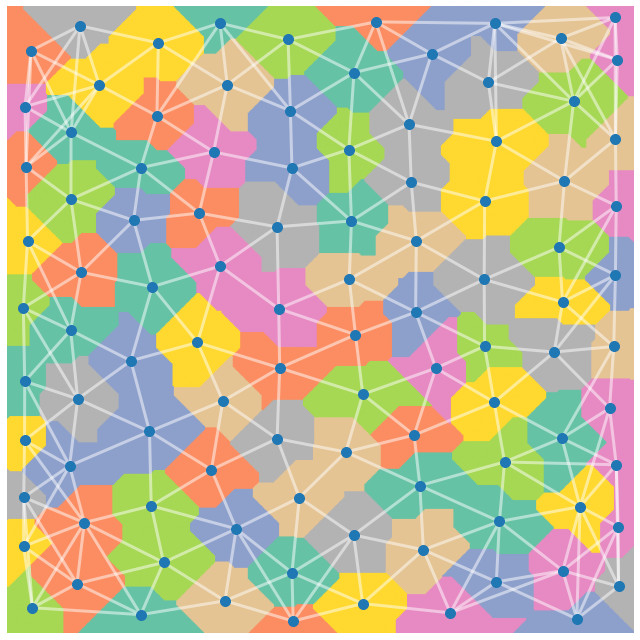

In [22]:
fig, ax = ty.showim(color.label2rgb(masks, bg_label=0, colors=label_cmap), origin='lower')
ty.plot_network(coords, pairs, col_edges='w', size_nodes=100, ax=ax, linewidth=linewidth)
plt.axis('off')

### radial distance neighbors

The radial distance neighbors  method define edges between each node and nodes that are closer than a given distance threshold. It is well suited to model interaction by diffusing chemicals for instance.

In [23]:
pairs = ty.build_rdn(coords, r=80)
distances = ty.distance_neighbors(coords, pairs)

(-11.375231596171338, 511.2509826531721, -15.221645021645024, 514.756586270872)

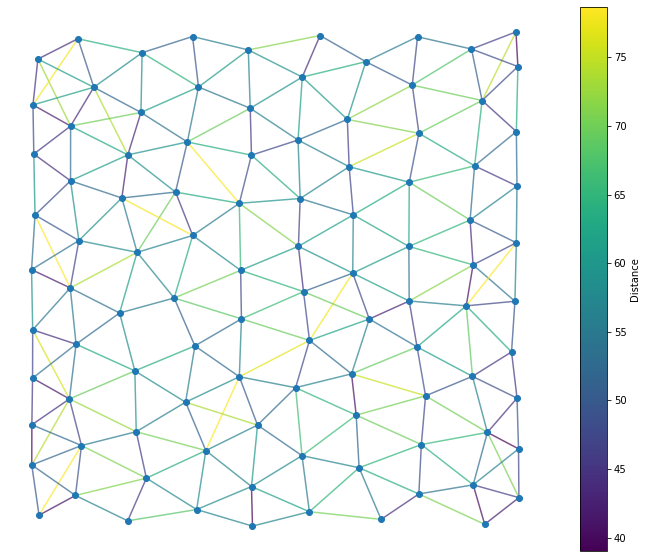

In [24]:
ty.plot_network_distances(coords, pairs, distances, figsize=(13,10))
plt.axis('off')

(-0.5, 499.5, -0.5, 499.5)

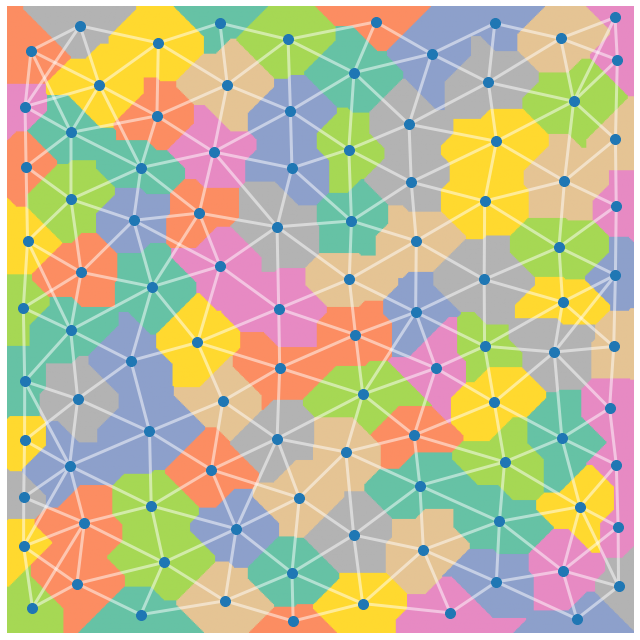

In [25]:
fig, ax = ty.showim(color.label2rgb(masks, bg_label=0, colors=label_cmap), origin='lower')
ty.plot_network(coords, pairs, col_edges='w', size_nodes=100, ax=ax, linewidth=linewidth)
plt.axis('off')